In [3]:
library(outbreaks)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [4]:
head(influenza_england_1978_school)

date,in_bed,convalescent
<date>,<int>,<int>
1978-01-22,3,0
1978-01-23,8,0
1978-01-24,26,0
1978-01-25,76,0
1978-01-26,225,9
1978-01-27,298,17


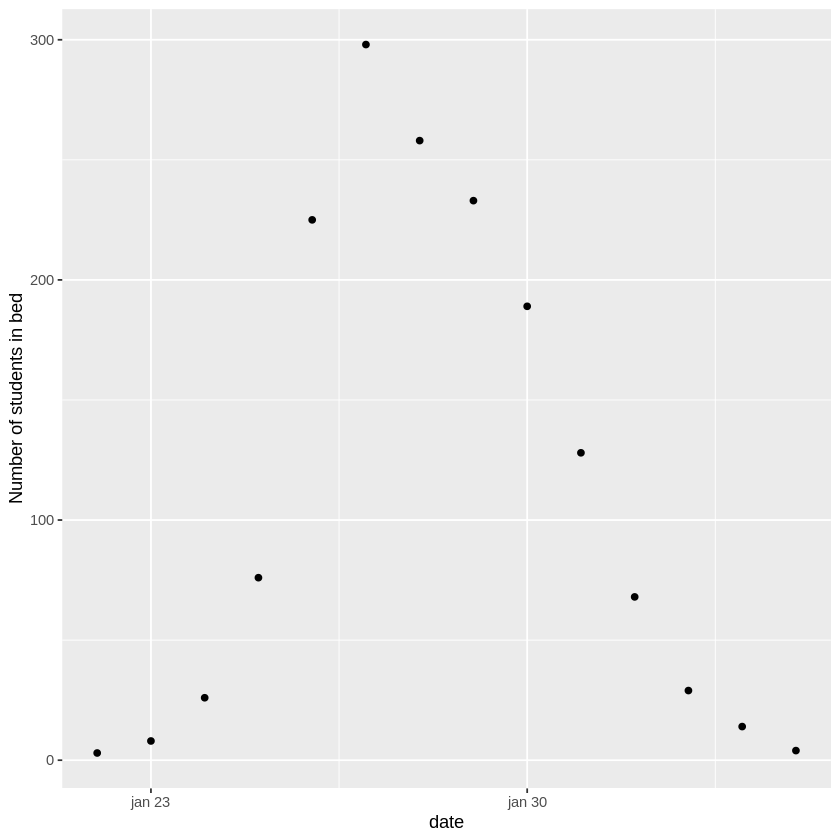

In [5]:
ggplot(data = influenza_england_1978_school) + 
  geom_point(mapping = aes(x = date, y = in_bed)) + 
  labs(y = "Number of students in bed")

In [6]:
library(rstan)
library(gridExtra)
rstan_options (auto_write = TRUE)
options (mc.cores = parallel::detectCores ())
set.seed(3) # for reproductibility

Loading required package: StanHeaders
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [30]:
# time series of cases
cases <- influenza_england_1978_school$in_bed  # Number of students in bed

# total count
N <- 763;

# times
n_days <- length(cases) 
t <- seq(1, n_days, by = 1)

#initial conditions
t0 = 0 
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

# data for Stan
data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases)

# number of MCMC steps
niter <- 2000

In [11]:
data(influenza_england_1978_school)
Ndata <- 763
sol <- influenza_england_1978_school
sol$time <- as.numeric(sol$date-min(sol$date)) + 2
sol$I <- sol$in_bed
forfit.sol <- sol
noisy_I <- forfit.sol$I/Ndata
iniTime <- 0
iniI <- 1/Ndata

epi.data <- list(
  n_obs = length(noisy_I),
  t0 = iniTime,
  ts = forfit.sol$time,
  y_init = iniI,
  y = noisy_I,
  ab = 1,
  bb = 0.010,
  ag = 1,
  bg = 0.010,
#   mu_beta = 0,
#   sigma_beta = 1,
#   mu_gamma = 0,
#   sigma_gamma = 1,
  as = 9, #254,
  bs = 1#350-254
)
# plot(epi.data$ts, epi.data$y, xlab = "ts", ylab = "y")

In [11]:
start_time <- Sys.time()

end_time <- Sys.time()

end_time - start_time

Time difference of 1.001077 mins

In [45]:
stan_code <- "/home/marcio/Projects/R0_uncertainty/R0_uncertainty/code/stan/model_test.stan"

In [46]:
model <- stan_model(stan_code)

In [47]:
fit_sir_negbin <- sampling(model,
                data = data_sir,
                iter = niter,
                chains = 4)


Divergences:


0 of 4000 iterations ended with a divergence.



Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 10.



Energy:


E-BFMI indicated no pathological behavior.


Inference for Stan model: model_test.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          1.73    0.00 0.05 1.63 1.70 1.73 1.77  1.84  1931    1
gamma         0.54    0.00 0.05 0.46 0.51 0.54 0.57  0.64  1949    1
R0            3.22    0.01 0.27 2.74 3.04 3.21 3.38  3.81  2085    1
recovery_time 1.86    0.00 0.16 1.57 1.76 1.85 1.96  2.19  1965    1

Samples were drawn using NUTS(diag_e) at Mon Jun  8 18:51:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


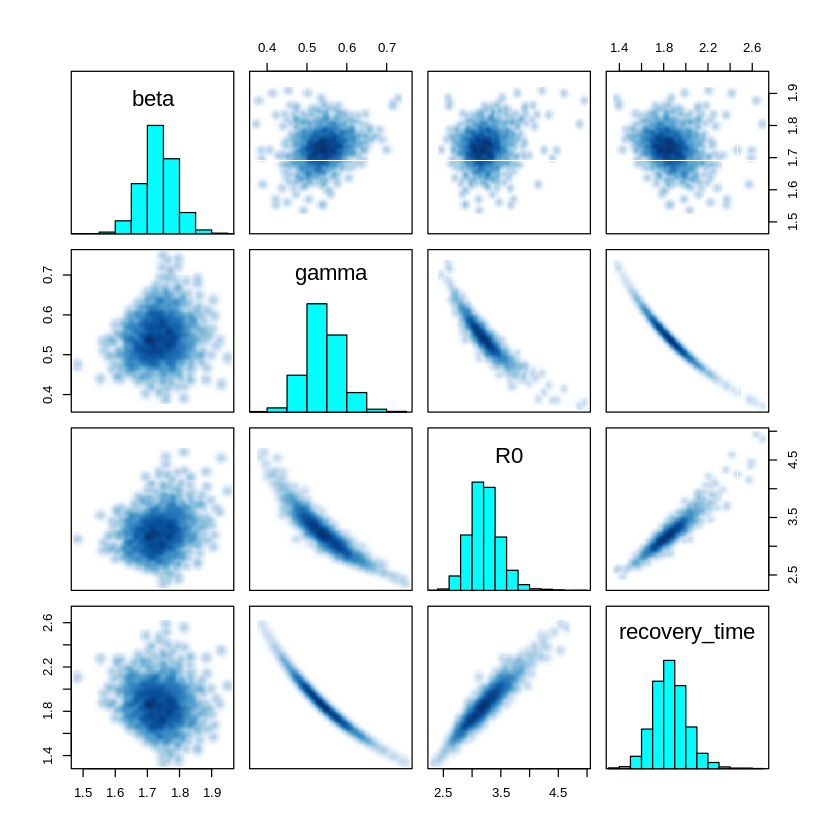

ERROR: Error in check_pars(allpars, pars): no parameter y_rep


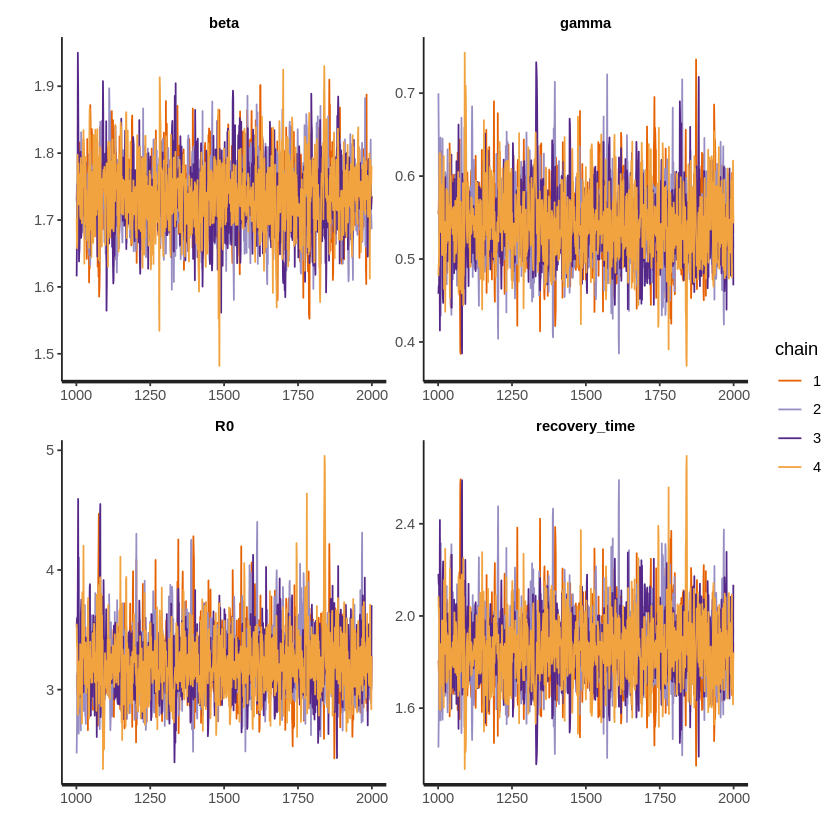

In [62]:
SIR.posterior.s1 <- sampling(model, data = data_sir, chains = 4, control = list(adapt_delta = .99))
check_hmc_diagnostics(SIR.posterior.s1)
print(SIR.posterior.s1, pars = c('beta', 'gamma', "R0", "recovery_time"))
pairs(SIR.posterior.s1, pars = c('beta', 'gamma', "R0", "recovery_time"))
stan_trace(SIR.posterior.s1, pars = c('beta', 'gamma', "R0", "recovery_time"))
simulated_trajectories.s1 <- extract(SIR.posterior.s1, 'y_rep')$y_rep
predicted.s1 <- data.frame(
  time = epi.data$ts,
  lower = apply(simulated_trajectories.s1, 2, function(x) as.numeric(quantile(x, probs = .025))),
  post_mean = colMeans(simulated_trajectories.s1),
  upper = apply(simulated_trajectories.s1, 2, function(x) as.numeric(quantile(x, probs = .975))),
  s = "1"
)

In [48]:
pars=c('beta', 'gamma', "R0", "recovery_time")

In [49]:
print(fit_sir_negbin, pars = pars)

Inference for Stan model: model_test.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          1.73    0.00 0.05 1.63 1.70 1.73 1.76  1.84  2773    1
gamma         0.54    0.00 0.04 0.46 0.51 0.54 0.57  0.64  2384    1
R0            3.21    0.01 0.27 2.73 3.04 3.19 3.37  3.80  2290    1
recovery_time 1.86    0.00 0.15 1.57 1.75 1.85 1.95  2.19  2390    1

Samples were drawn using NUTS(diag_e) at Mon Jun  8 18:33:50 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


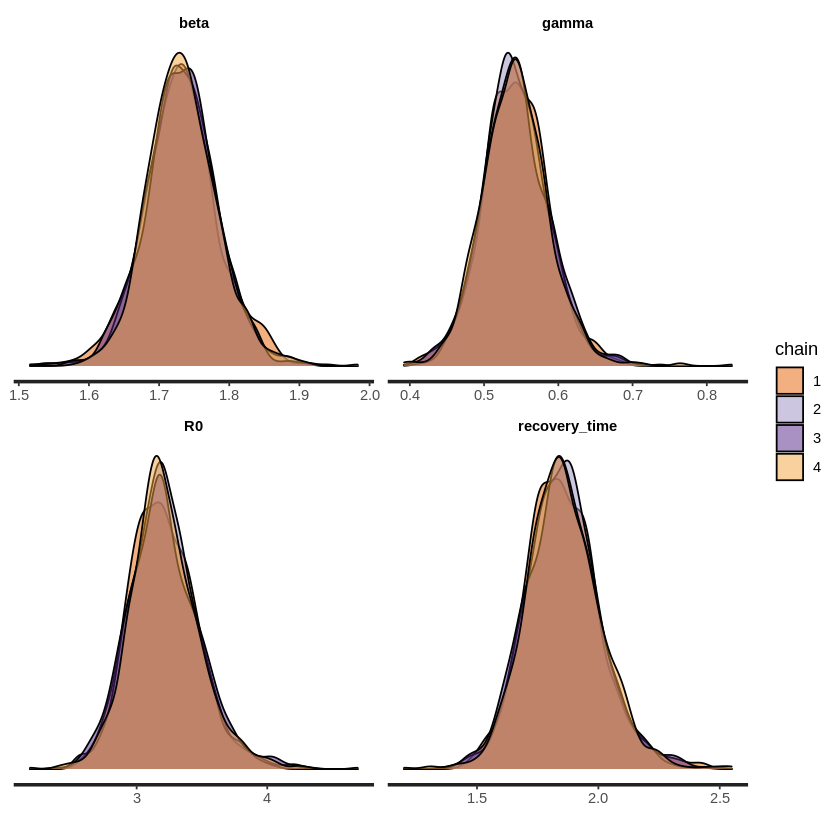

In [50]:
stan_dens(fit_sir_negbin, pars = pars, separate_chains = TRUE)

In [57]:
smr_pred <- cbind(as.data.frame(summary(
  fit_sir_negbin, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), t, cases)

In [59]:
colnames(smr_pred)

[1] "mean"    "se_mean" "sd"      "5%"      "50%"     "95%"     "n_eff"  
 [8] "Rhat"    "t"       "cases"

In [60]:
make.names(colnames(smr_pred))

[1] "mean"    "se_mean" "sd"      "X5."     "X50."    "X95."    "n_eff"  
 [8] "Rhat"    "t"       "cases"

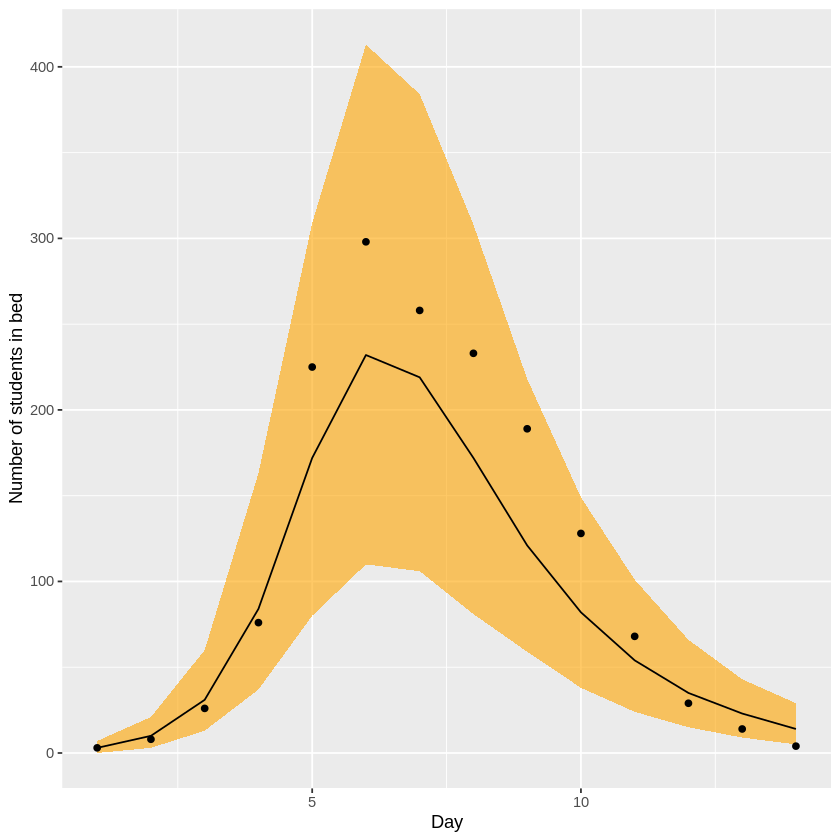

In [51]:
smr_pred <- cbind(as.data.frame(summary(
  fit_sir_negbin, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), t, cases)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "orange", alpha = 0.6) +
  geom_line(mapping = aes(x = t, y = X50.)) + 
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Number of students in bed")